In [572]:
import pickle
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
from nltk. corpus import gutenberg
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from gensim.models import KeyedVectors
from keras.layers import Input, Dense, Lambda, Layer, LSTM, Reshape, TimeDistributed, Dropout, Bidirectional, RepeatVector, Flatten
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
import gensim.downloader as api

from gensim.models.word2vec import Word2Vec
import pandas as pd
import re
import matplotlib.pyplot as plt
from gensim.test.utils import common_texts, get_tmpfile

# Preprocessing Text

The preprocessing code is data specific.  
  
It is an example of how one can use a pre-trained word2vec to embed sentences into a vector space.

# TODO train w2v model

In [226]:
# corpus = api.load('20-newsgroups')
# info = api.info()  # show info about available models/datasets
# word2vec_model = api.load("glove-twitter-100")  # download the model and return as object ready for use
# word2vec_model.most_similar("cat")

In [1200]:
w2v_model.save("word2vec.model")

In [3]:
w2v_model = Word2Vec.load("word2vec.model")

In [635]:
dataset = pd.read_csv("shortjokes.csv").set_index("ID")

In [636]:
dataset_1 = pd.read_csv("jokes_score_name_clean.csv")

In [637]:
dataset_1["Joke"] = dataset_1["q"] + " " + dataset_1["a"]

In [638]:
dataset_2 = pd.read_csv("qajokes1.1.2.csv")
dataset_2["Joke"] = dataset_2["Question"] + " " + dataset_2["Answer"]

In [639]:
sentences = dataset["Joke"].tolist() + dataset_1["Joke"].tolist() + dataset_2["Joke"].tolist()

In [640]:
def preprocess_text(text):
    return re.sub(
        r"[^\w\s']", 
        "", 
        text
    ).lower().split()

In [641]:
preprocessed_sentences = [preprocess_text(t) for t in sentences]

In [11]:
len(sentences)

440099

In [12]:
# w2v_model = Word2Vec(preprocessed_sentences, size=100, window=10, workers=16, iter=100)
# w2v_model = word2vec_model

In [13]:
w2v_model.wv.most_similar("bolt")

[('phelps', 0.5148839950561523),
 ("bolt's", 0.5110259056091309),
 ('bloodbath', 0.45941269397735596),
 ('gust', 0.4141930341720581),
 ('nada', 0.4051152169704437),
 ('glimpse', 0.40208110213279724),
 ('key', 0.3946117162704468),
 ('ricocheted', 0.39381635189056396),
 ('lightning', 0.38503432273864746),
 ('binos', 0.38127273321151733)]

In [14]:
w2v = w2v_model.wv

Preprocessing text from a variety of different sources.

(array([ 45000., 233729., 105550.,  20059.,   4429.,   2733.,   2216.,
          2010.,   1910.,   1746.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

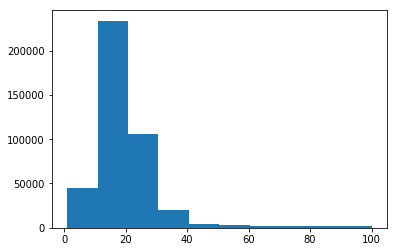

In [632]:
plt.hist([len(s) + 1 for s in preprocessed_sentences if len(s) < 100])

# No LSTM variant

In [642]:
# preprocessed_sentences = [preprocess_text(t) for t in dataset_2["Joke"]]

In [703]:
original_dim = 2000
original_dims = (2000, )

In [704]:
def vectorize_sentence(sentence):
    concat_vector = []
    for word in sentence:
        try:
            concat_vector.append(w2v[word])
        except:
            return
    return [a for vector in concat_vector for a in vector]

In [705]:
vectorized_sentences = [vectorize_sentence(sentence) for sentence in preprocessed_sentences if (len(sentence) < 20) & (len(sentence) > 10)]

In [706]:
vectorized_sentences = [sentence for sentence in vectorized_sentences if sentence]

In [707]:
from keras.preprocessing import sequence
vectorized_padded = sequence.pad_sequences(vectorized_sentences, maxlen=original_dim, padding="post", truncating="post")

In [708]:
# normalized_vectorized_padded = (vectorized_padded - vectorized_padded.min()) / (vectorized_padded.max() - vectorized_padded.min())# + 0.01*np.random.randn(*normalized_vectorized_padded.shape)
normalized_vectorized_padded = vectorized_padded

# LSTM variant

In [313]:
preprocessed_sentences = [preprocess_text(t) for t in dataset_2["Joke"]]

In [322]:
def vectorize_sentence(sentence):
    concat_vector = []
    for word in sentence:
        try:
            concat_vector.append(w2v[word])
        except:
            return
    return concat_vector

In [323]:
vectorized_sentences = [vectorize_sentence(sentence) for sentence in preprocessed_sentences if (len(sentence) < 20) & (len(sentence) > 10)]

In [324]:
vectorized_sentences = [sentence for sentence in vectorized_sentences if sentence]

In [325]:
vectorized_padded = np.array([sentence + [[0] * 100] * (20 - len(sentence)) for sentence in vectorized_sentences])

In [328]:
normalized_vectorized_padded = (vectorized_padded - vectorized_padded.min()) / (vectorized_padded.max() - vectorized_padded.min())

In [329]:
original_dims = (20, 100)
original_dim = 2000

# LSTM tokens variant

In [ ]:
preprocessed_sentences = [preprocess_text(t) for t in dataset_2["Joke"]]

In [ ]:
def create_dictionary():
    pass

def vectorize_sentence(sentence):
    concat_vector = []
    for word in sentence:
        try:
            concat_vector.append(w2v[word])
        except:
            return
    return concat_vector

In [ ]:
vectorized_sentences = [vectorize_sentence(sentence) for sentence in preprocessed_sentences if (len(sentence) < 20) & (len(sentence) > 10)]

In [ ]:
vectorized_sentences = [sentence for sentence in vectorized_sentences if sentence]

In [ ]:
vectorized_padded = np.array([sentence + [[0] * 100] * (20 - len(sentence)) for sentence in vectorized_sentences])

In [ ]:
normalized_vectorized_padded = (vectorized_padded - vectorized_padded.min()) / (vectorized_padded.max() - vectorized_padded.min())

In [ ]:
original_dims = (20, 100)
original_dim = 2000

It's important to shuffle the text vectors before splitting them into test and train samples.   
  
This is done to avoid clumping text with similar context and style in the dataset because it can confuse the neural network during training.

In [709]:
from sklearn.model_selection import train_test_split

In [710]:
vectorized_train, vectorized_test = train_test_split(normalized_vectorized_padded, test_size=0.3)

In [711]:
batch_size = 500
def cut_dataset(dataset, batch_size):
    rest = len(dataset) % batch_size
    return dataset[:-rest]

vectorized_train = cut_dataset(vectorized_train, batch_size)
vectorized_test = cut_dataset(vectorized_test, batch_size)

In [712]:
help_vectorized_train = vectorized_train.reshape(-1, original_dim)
help_vectorized_test = vectorized_test.reshape(-1, original_dim)

Get w2v embeddings for text with fixed length

# Variational Autoencoder

1. Values are normalized for sigmoid - done
2. LSTM usage in encoder - done
3. LSTM usage in decoder - done (without Flatten - not done)
4. Layers dropout - not done, underfitting
5. Tokens instead of word2vec vectors? Or use something instead of binary crossentropy?

Binary crossentropy for non binary values?!

Use something that can replace E[log P(X|z)]

Why cross-entropy?

In [713]:
from keras import callbacks

In [714]:
latent_dim = 100
lstm_dim = 100
intermediate_dim = 1000
epochs = 200
epsilon_std = 1.

In [715]:
x = Input(shape=original_dims)
h = Dense(intermediate_dim, activation='relu')(x)
h_mean = Dense(latent_dim, activation='relu')(h)
z_mean = Dense(latent_dim)(h_mean)
h_log_var = Dense(latent_dim, activation='relu')(h)
z_log_var = Dense(latent_dim)(h_log_var)

In [716]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [717]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='linear') 

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [718]:
# def xent_loss(y_true, y_pred):
# #     return K.sum(K.binary_crossentropy(y_true, y_pred), axis=1)
#     return original_dim * K.binary_crossentropy(y_true, y_pred)

# def kl_loss(y_true, y_pred):
# #     return 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var, axis=1)
#     return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

# def vae_loss(y_true, y_pred):
# #     return xent_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
#     return K.mean(xent_loss(y_true, y_pred) + kl_loss(y_true, y_pred))

def vae_loss(x, x_decoded_mean):
#     xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    xent_loss = original_dim * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [719]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss) #metrics=[xent_loss, kl_loss])

In [720]:
# vae.predict(vectorized_train, batch_size=batch_size) - vectorized_train

In [ ]:
#### checkpoint
cp = [callbacks.ModelCheckpoint(filepath="/tmp/model.h5", verbose=1)]

#train
vae.fit(vectorized_train, help_vectorized_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(vectorized_test, help_vectorized_test),
        callbacks=cp)

Train on 125000 samples, validate on 53500 samples
Epoch 1/200
125000/125000 [==============================] - 28s 224us/step - loss: 8705.8093 - val_loss: 7783.2301

Epoch 00001: saving model to /tmp/model.h5
Epoch 2/200
125000/125000 [==============================] - 19s 150us/step - loss: 7524.8679 - val_loss: 7353.1838

Epoch 00002: saving model to /tmp/model.h5
Epoch 3/200
125000/125000 [==============================] - 19s 149us/step - loss: 7211.2379 - val_loss: 7131.5158

Epoch 00003: saving model to /tmp/model.h5
Epoch 4/200
125000/125000 [==============================] - 19s 148us/step - loss: 7015.4422 - val_loss: 6980.6946

Epoch 00004: saving model to /tmp/model.h5
Epoch 5/200
125000/125000 [==============================] - 19s 149us/step - loss: 6874.3819 - val_loss: 6865.3088

Epoch 00005: saving model to /tmp/model.h5
Epoch 6/200
125000/125000 [==============================] - 19s 153us/step - loss: 6767.9304 - val_loss: 6780.2317

Epoch 00006: saving model to /tm

In [621]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=( latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [622]:
test_model = Model(x, z_mean)
np.min(test_model.predict(vectorized_test[0:10])), np.max(test_model.predict(vectorized_test[0:10]))

(-3.4065683, 3.185115)

# Generating Text From Latent Space

In [623]:
# some matrix magic
def sent_parse(sentence, mat_shape):
    data_concat = []
    word_vecs = vectorize_sentences(sentence)
    for x in word_vecs:
        data_concat.append(list(itertools.chain.from_iterable(x)))
    zero_matr = np.zeros(mat_shape)
    zero_matr[0] = np.array(data_concat)
    return zero_matr

In [624]:
def print_sentence_with_w2v(sent_vect):
#     sent_vect = sent_vect * (vectorized_padded.max() - vectorized_padded.min()) + vectorized_padded.min()
    word_sent = ''
    tocut = sent_vect
    for i in range (int(len(sent_vect)/100)):
        word_sent += w2v.most_similar(positive=[tocut[:100]], topn=1)[0][0]
        word_sent += ' '
        tocut = tocut[100:]
    print(word_sent)

In [625]:
# input: encoded sentence vector
# output: encoded sentence vector in dataset with highest cosine similarity
def find_similar_encoding(sent_vect):
    all_cosine = []
    for sent in sent_encoded:
        result = 1 - spatial.distance.cosine(sent_vect, sent)
        all_cosine.append(result)
    data_array = np.array(all_cosine)
    maximum = data_array.argsort()[-3:][::-1][1]
    new_vec = sent_encoded[maximum]
    return new_vec

In [626]:
# input: two points, integer n
# output: n equidistant points on the line between the input points (inclusive)
def shortest_homology(point_one, point_two, num):
    dist_vec = point_two - point_one
    sample = np.linspace(0, 1, num, endpoint = True)
    hom_sample = []
    for s in sample:
        hom_sample.append(point_one + s * dist_vec)
    return hom_sample

In [627]:
# input: two written sentences, VAE batch-size, dimension of VAE input
# output: the function embeds the sentences in latent-space, and then prints their generated text representations
# along with the text representations of several points in between them
def sent_2_sent(sent1,sent2, batch, dim):
    a = sent_parse([sent1], (batch,dim))
    b = sent_parse([sent2], (batch,dim))
    encode_a = encoder.predict(a, batch_size = batch)
    encode_b = encoder.predict(b, batch_size = batch)
    test_hom = hom_shortest(encode_a[0], encode_b[0], 5)
    
    for point in test_hom:
        p = generator.predict(np.array([point]))[0]
        print_sentence(p)

Printing sentences from the training set and comparing them with the original will test whether the custom print function works properly.

In [628]:
# sentences = [vectorize_sentence(preprocess_text("zero should be less than or equal to zero"))]
# padded_sentences = sequence.pad_sequences(sentences, maxlen=original_dim, padding="post", truncating="post")
padded_sentences = vectorized_train[0:10]

The encoder takes the training set of sentence vectors (concatenanted word vectors) and embeds them into a lower dimensional vector space.

In [629]:
sent_encoded = encoder.predict(padded_sentences)

In [630]:
sent_encoded.shape

(10, 100)

The decoder takes the list of latent dimensional encodings from above and turns them back into vectors of their original dimension.

In [631]:
sent_decoded = generator.predict(sent_encoded)

In [632]:
vectorized_train[0].tolist()

[11,
 4,
 4,
 -1,
 -7,
 -2,
 -3,
 -1,
 4,
 5,
 0,
 -6,
 1,
 -1,
 2,
 3,
 0,
 3,
 9,
 5,
 2,
 2,
 0,
 -3,
 1,
 -5,
 2,
 8,
 8,
 1,
 5,
 0,
 -3,
 0,
 -1,
 -2,
 5,
 0,
 -5,
 1,
 1,
 -1,
 -1,
 -5,
 -7,
 -3,
 7,
 3,
 -3,
 6,
 -4,
 1,
 5,
 -1,
 3,
 0,
 0,
 0,
 5,
 0,
 2,
 -4,
 0,
 -3,
 -4,
 -7,
 0,
 -5,
 -1,
 6,
 -5,
 -1,
 0,
 3,
 7,
 5,
 -2,
 5,
 2,
 0,
 0,
 0,
 0,
 5,
 -3,
 -4,
 4,
 2,
 2,
 3,
 -2,
 0,
 -3,
 0,
 1,
 -1,
 -1,
 0,
 -10,
 4,
 -1,
 0,
 1,
 -3,
 -1,
 0,
 2,
 1,
 4,
 0,
 0,
 2,
 0,
 -2,
 0,
 2,
 1,
 0,
 -3,
 -3,
 -1,
 2,
 4,
 1,
 -1,
 1,
 0,
 0,
 2,
 0,
 -2,
 0,
 1,
 -2,
 -1,
 0,
 0,
 -1,
 2,
 4,
 -4,
 0,
 -1,
 0,
 -1,
 -1,
 0,
 1,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 -2,
 1,
 1,
 4,
 0,
 -1,
 1,
 1,
 -1,
 0,
 -2,
 0,
 1,
 0,
 -2,
 -1,
 1,
 3,
 -1,
 1,
 -2,
 -2,
 0,
 0,
 0,
 -2,
 -3,
 1,
 1,
 1,
 -2,
 0,
 -4,
 0,
 1,
 0,
 -1,
 0,
 -1,
 0,
 -1,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -2,
 0,
 0,
 -2,
 3,
 0,
 0,
 1,
 -1,
 -2,
 0,
 1,
 -2,
 1,
 0,
 0,
 0,
 -1,
 1,
 -1,
 2,
 -4,
 1,
 1,
 4,
 -1

In [633]:
sent_decoded[0].tolist()

[10.292098999023438,
 4.007075309753418,
 3.8734469413757324,
 -0.3958585560321808,
 -5.327584266662598,
 -1.147791862487793,
 -2.847898244857788,
 -0.7675120830535889,
 2.911266326904297,
 4.017035484313965,
 -0.3958999514579773,
 -6.533461093902588,
 1.2897509336471558,
 -0.4881402254104614,
 1.6625556945800781,
 2.7773900032043457,
 -0.22869598865509033,
 1.9939302206039429,
 7.99796199798584,
 4.870890140533447,
 1.6457968950271606,
 1.8600523471832275,
 -0.014736175537109375,
 -2.4909653663635254,
 0.18179559707641602,
 -4.635962009429932,
 1.6137866973876953,
 6.973522663116455,
 7.398083686828613,
 1.1160871982574463,
 4.805074214935303,
 0.11988791823387146,
 -2.885666608810425,
 0.5359637141227722,
 -0.8296325206756592,
 -1.6863164901733398,
 3.921964645385742,
 -0.824578046798706,
 -5.026695251464844,
 0.87347012758255,
 0.7698076367378235,
 -0.47742265462875366,
 -0.3201391100883484,
 -4.602727890014648,
 -5.579717636108398,
 -2.6802244186401367,
 6.1884355545043945,
 2.4137

In [634]:
for i, sentence in enumerate(sent_decoded):
    print("Original...")
    print_sentence_with_w2v(help_vectorized_test[i])
    print("Generated...")
    print_sentence_with_w2v(sentence)
    print("===========================")

Original...
what do you call a muslim basketball player's best move islam dunk the the the 
Generated...
why do hitler kill he because they come fish and bullets it looked realistic greatgrandchildren 
Original...
what's it called when a priest is always late collared people's time the the the 
Generated...
where'd you get it the parrot said africa they have millions of them impeach ihop 
Original...
where does a snowman keep his money in the snowbank i'll see myself out the 
Generated...
what kind of he is twentythird before he got married a governor biased subreddit attaches 
Original...
how often do you find a eunuch in westeros it varys the the the the 
Generated...
why don't you grow them flies dog i'll let them go through see to greatgrandchildren 
Original...
what did the stop light say to the car don't look i am changing the 
Generated...
what is a nephew quantity of sense that you'll never understand you arrow legend barb 
Original...
why did the apple cross the road to get to

The encoder trained above embeds sentences (concatenated word vetors) into a lower dimensional space. The code below takes two of these lower dimensional sentence representations and finds five points between them. It then uses the trained decoder to project these five points into the higher, original, dimensional space. Finally, it reveals the text represented by the five generated sentence vectors by taking each word vector concatenated inside and finding the text associated with it in the word2vec used during preprocessing.

In [ ]:
test_hom = shortest_homology(sent_encoded[3], sent_encoded[10], 5)
for point in test_hom:
    p = generator.predict(np.array([point]))[0]
    print_sentence_with_w2v(p)

The code below does the same thing, with one important difference. After sampling equidistant points in the latent space between two sentence embeddings, it finds the embeddings from our encoded dataset those points are most similar to. It then prints the text associated with those vectors.
  
This allows us to explore how the Variational Autoencoder clusters our dataset of sentences in latent space. It lets us investigate whether sentences with similar concepts or grammatical styles are represented in similar areas of the lower dimensional space.

In [ ]:
test_hom = shortest_homology(sent_encoded[2], sent_encoded[1500], 20)
for point in test_hom:
    p = generator.predict(np.array([find_similar_encoding(point)]))[0]
    print_sentence_with_w2v(p)

# Generative Adversarial Network